In [35]:
## import packages and helper functions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import statistics
import copy

training data

In [36]:
# import data
df = pd.read_csv("data/95_missing_5000sample.csv")
data = df.to_numpy()
(l, w) = data.shape

In [37]:
x_train = np.zeros((l, w*2))
for i in range(l):
    for d in range(w):
        p = data[i, d]
        # update output array
        if p == 0:
            # print("shouldn't be here")
            missing_ind = np.random.choice(2, 1)[0]
            x_train[i, d*2] = missing_ind
            x_train[i, d*2+1] = missing_ind
        else:
            x_train[i, d*2] = p # score
            x_train[i, d*2+1] = 1-p # 1-score

In [38]:
# x_train = data.reshape((-1, 28))
# x_train.shape

In [39]:
from sklearn.model_selection import train_test_split

x_train, x_val = train_test_split(x_train, test_size=0.20)

Autoencoder model

In [40]:
(l, w)

(5000, 2)

In [41]:
class AE(torch.nn.Module):
    def __init__(self):
        super().__init__()
        n_domains = 2
         
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(n_domains * 2, 10),
            torch.nn.Sigmoid(),
            torch.nn.Linear(10, 5)
        )
         
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(5, 10),
            torch.nn.Sigmoid(),
            torch.nn.Linear(10, n_domains * 2),
            torch.nn.Sigmoid()
        )
 
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [42]:
# Model Initialization
model = AE()
 
# Validation using MSE Loss function
loss_function = torch.nn.MSELoss()
 
# Using an Adam Optimizer
optimizer = torch.optim.Adam(model.parameters(),
                             lr = 1e-4,
                             weight_decay = 1e-8)

In [43]:
def missing(arr):
    return arr[0] == arr[1]

In [44]:
import wandb

wandb.init(project='autoencoder_test_model_debug')
wandb.watch(model, log='all')

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


[]

In [45]:
epochs = 25
outputs = []
losses = []
val_losses = []
epoch_loss = []
val_epoch_loss = []

for epoch in range(epochs):
    for session in x_train:

      optimizer.zero_grad()

      # Output of Autoencoder
      session_rs = session.reshape(-1, w * 2)
      session_t = torch.from_numpy(session_rs)
      session_t = session_t.clone().detach().requires_grad_(True).type(torch.float32)
      reconstructed = model(session_t)

      # handle missing value
      missing_exists = False
      missing_domains = []
      for domain in range(w):
        if missing(session[domain*2:domain*2+2]):
          missing_exists = True
          missing_domains.append(domain)
          
      if missing_exists:
        session_dc = copy.deepcopy(session)
        for d in missing_domains:
          target = reconstructed.detach().numpy()[0][d*2:d*2+2]
          session_dc[d*2:d*2+2] = target
        session_dc = session_dc.reshape(-1, w * 2)
        session_t = torch.from_numpy(session_dc)
        session_t = session_t.clone().detach().requires_grad_(True).type(torch.float32)
       
      # Calculating the loss function
      loss = loss_function(reconstructed, session_t)
      
      loss.backward()
      optimizer.step()
      # print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')
       
      # Storing the losses in a list for plotting
      epoch_loss.append(loss.item())

    losses.append(statistics.mean(epoch_loss))
    print(f'Epoch [{epoch + 1}/{epochs}], Loss: {statistics.mean(epoch_loss):.4f}')
    epoch_loss = []
    outputs.append((epochs, session_t, reconstructed))

    with torch.no_grad():
      for val in x_val:
        val_rs = val.reshape(-1, w * 2)
        val_t = torch.from_numpy(val_rs)
        val_t = val_t.clone().detach().type(torch.float32)
        answer = model(val_t)
        val_loss = loss_function(answer, val_t)
        val_epoch_loss.append(val_loss.item())
    val_losses.append(statistics.mean(val_epoch_loss))

Epoch [1/25], Loss: 0.0038
Epoch [2/25], Loss: 0.0038
Epoch [3/25], Loss: 0.0038
Epoch [4/25], Loss: 0.0037
Epoch [5/25], Loss: 0.0037
Epoch [6/25], Loss: 0.0037
Epoch [7/25], Loss: 0.0037
Epoch [8/25], Loss: 0.0037
Epoch [9/25], Loss: 0.0036
Epoch [10/25], Loss: 0.0036
Epoch [11/25], Loss: 0.0035
Epoch [12/25], Loss: 0.0035
Epoch [13/25], Loss: 0.0034
Epoch [14/25], Loss: 0.0032
Epoch [15/25], Loss: 0.0031
Epoch [16/25], Loss: 0.0029
Epoch [17/25], Loss: 0.0026
Epoch [18/25], Loss: 0.0023
Epoch [19/25], Loss: 0.0019
Epoch [20/25], Loss: 0.0015
Epoch [21/25], Loss: 0.0011
Epoch [22/25], Loss: 0.0007
Epoch [23/25], Loss: 0.0005
Epoch [24/25], Loss: 0.0003
Epoch [25/25], Loss: 0.0002


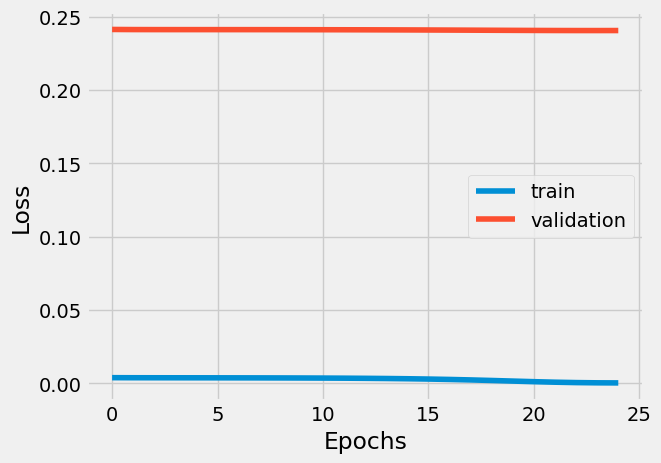

In [46]:
 # Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Epochs')
plt.ylabel('Loss')
 
# Plotting
with torch.no_grad():
   plt.plot(losses)
   plt.plot(val_losses)
   plt.legend(["train", "validation"])

wandb.log(
    {
        "train val loss": wandb.plot.line_series(
            xs=range(epochs),
            ys=[losses, val_losses],
            keys=["Train", "Validation"],
            title="training and validation loss",
            xname="epochs",
        )
    }
)

In [47]:
np.mean(x_train, axis=0)

array([0.49929884, 0.49970116, 0.50298793, 0.50201207])

Testing all missing average

In [48]:
missing_data = pd.read_csv("data/all_1_500.csv")
missing_data = missing_data.to_numpy()
(l, w) = missing_data.shape

In [49]:
missing_set = np.zeros((l, w*2))
for i in range(l):
    for d in range(w):
        p = missing_data[i, d]
        # update output array
        missing_set[i, d*2] = p
        missing_set[i, d*2+1] = p

In [50]:
total = np.array([0.0, 0.0, 0.0, 0.0])
with torch.no_grad():
    for row in missing_set:
        temp = row.reshape(-1, w * 2)
        temp = torch.from_numpy(temp)
        temp = temp.clone().detach().type(torch.float32)
        output = model(temp).detach().numpy()[0]
        total = output + total

total = total/l
total

array([0.48413864, 0.52297401, 0.5165202 , 0.48637348])

In [51]:
missing_data = pd.read_csv("data/all_0_500.csv")
missing_data = missing_data.to_numpy()
(l, w) = missing_data.shape

In [52]:
missing_set = np.zeros((l, w*2))
for i in range(l):
    for d in range(w):
        p = missing_data[i, d]
        # update output array
        missing_set[i, d*2] = p
        missing_set[i, d*2+1] = p

total = np.array([0.0, 0.0, 0.0, 0.0])
with torch.no_grad():
    for row in missing_set:
        temp = row.reshape(-1, w * 2)
        temp = torch.from_numpy(temp)
        temp = temp.clone().detach().type(torch.float32)
        output = model(temp).detach().numpy()[0]
        total = output + total

total = total/l
total

array([0.46647894, 0.54300725, 0.53586137, 0.46732584])

No missing test

In [53]:
test_data = pd.read_csv("data/test_dataset_no_missing_2.csv")
test_data = test_data.to_numpy()
(l, w) = test_data.shape

In [54]:
x_test = np.zeros((l, w*2))
for i in range(l):
    for d in range(w):
        p = test_data[i, d]
        x_test[i, d*2] = p # score
        x_test[i, d*2+1] = 1-p # 1-score

In [55]:
total_loss = 0
with torch.no_grad():
    for row in x_test:
        temp = row.reshape(-1, w * 2)
        temp = torch.from_numpy(temp)
        temp = temp.clone().detach().type(torch.float32)
        
        output = model(temp)
        loss = loss_function(output, temp).detach().numpy()
        total_loss += loss

total_loss/l

0.05280764142633416

In [56]:
wandb.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Bad pipe message: %s [b"\xf5\n=9\xa0\xb31\xaf\xa1\xb8H\x0b\xcd\x10\xbbf'\x95\x00\x01|\x00\x00\x00\x01\x00\x02\x00\x03\x00\x04\x00\x05\x00\x06\x00\x07\x00\x08\x00\t\x00\n\x00\x0b\x00\x0c\x00\r\x00\x0e\x00\x0f\x00\x10\x00\x11\x00\x12\x00\x13\x00\x14\x00\x15\x00\x16\x00\x17\x00\x18\x00\x19\x00\x1a\x00\x1b\x00/\x000\x001\x002\x003\x004\x005\x006\x007\x008\x009\x00:\x00;\x00<\x00=\x00>\x00?\x00@\x00A\x00B\x00C\x00D\x00E\x00F\x00g\x00h\x00i\x00j\x00k\x00l\x00m\x00\x84\x00\x85\x00\x86\x00\x87\x00\x88\x00\x89\x00\x96\x00\x97\x00\x98\x00\x99\x00\x9a\x00\x9b\x00\x9c\x00\x9d\x00\x9e\x00\x9f\x00\xa0\x00\xa1\x00\xa2\x00\xa3\x00\xa4\x00\xa5\x00\xa6\x00\xa7\x00\xba\x00\xbb\x00\xbc\x00\xbd\x00\xbe\x00\xbf\x00\xc0\x00\xc1\x00\xc2\x00\xc3\x00\xc4\x00\xc5\x13\x01\x13\x02\x13\x03\x13\x04\x13\x05\xc0\x01\xc0\x02\xc0\x03\xc0\x04\xc0\x05\xc0\x06\xc0\x07\xc0\x08\xc0\t\xc0\n\xc0\x0b\xc0\x0c\xc0\r\xc0"]
Bad pipe message: %s [b'\x0f\xc0\x10\xc0\x11\xc0\x12\xc0\x13\xc0\x14\xc0\x15']
Bad pipe message: %s [b'\x0c\x